In [126]:
import pandas as pd
import requests
import json
import time
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(sum(map(ord, 'calmap')))
import seaborn as sns
import plotly.express as px 
from plotly_calplot import calplot

In [127]:
## Get the tokens from file to connect to Strava
with open('strava_tokens.json') as json_file:
    strava_tokens = json.load(json_file)
## If access_token has expired then use the refresh_token to get the new access_token
if strava_tokens['expires_at'] < time.time():
#Make Strava auth API call with current refresh token
    response = requests.post(
                        url = 'https://www.strava.com/oauth/token',
                        data = {
                                'client_id': open('client_id', 'r').read(),
                                'client_secret': open('client_secret', 'r').read(),
                                'grant_type': 'refresh_token',
                                'refresh_token': strava_tokens['refresh_token']
                                }
                    )
#Save response as json in new variable
    new_strava_tokens = response.json()
# Save new tokens to file
    with open('strava_tokens.json', 'w') as outfile:
        json.dump(new_strava_tokens, outfile)
#Use new Strava tokens from now
    strava_tokens = new_strava_tokens
#Loop through all activities
page = 1
url = "https://www.strava.com/api/v3/activities"
access_token = strava_tokens['access_token']
df = pd.DataFrame(
    columns = ['start_date_local', 'type', 'elapsed_time', 'distance', 'moving_time', 'total_elevation_gain',
         'max_heartrate', 'average_heartrate', 'average_cadence', 'max_speed', 'average_speed', 'location_country',
         'suffer_score', 'gear_id'
           ]
)
while True:
    
    # get page of activities from Strava
    r = requests.get(url + '?access_token=' + access_token + '&per_page=200' + '&page=' + str(page))
    r = r.json()
# if no results then exit loop
    if (not r):
        break
    
    for x in range(len(r)):
        df.loc[x + (page-1)*200, 'start_date_local'] = r[x].get('start_date_local')
        df.loc[x + (page-1)*200, 'type'] = r[x].get('type')
        df.loc[x + (page-1)*200, 'elapsed_time'] = r[x].get('elapsed_time')
        df.loc[x + (page-1)*200, 'distance'] = r[x].get('distance')
        df.loc[x + (page-1)*200, 'moving_time'] = r[x].get('moving_time')
        df.loc[x + (page-1)*200, 'total_elevation_gain'] = r[x].get('total_elevation_gain')
        df.loc[x + (page-1)*200, 'max_heartrate'] = r[x].get('max_heartrate')  # Use .get() to avoid KeyError
        df.loc[x + (page-1)*200, 'average_heartrate'] = r[x].get('average_heartrate')
        df.loc[x + (page-1)*200, 'average_cadence'] = r[x].get('average_cadence')
        df.loc[x + (page-1)*200, 'max_speed'] = r[x].get('max_speed')
        df.loc[x + (page-1)*200, 'average_speed'] = r[x].get('average_speed')
        df.loc[x + (page-1)*200, 'location_country'] = r[x].get('location_country')
        df.loc[x + (page-1)*200, 'suffer_score'] = r[x].get('suffer_score')
        df.loc[x + (page-1)*200, 'gear_id'] = r[x].get('gear_id')



    page += 1
gear_labels = {'g9741687': 'NIKE Pegasus', 'g12257864': 'ADIDAS Takumi Sen 8', 'g12818523': 'ASICS Noosa Tri 14', 
               'g16635719': 'SAUCONY Endorphin Pro 3', 'g9050085':'ASICS Noosa Tri 13', 'g10409096':'ASICS Novablast 2', 
               'None':'ASICS Noosa Tri 13'}

df['gear_id'] = df['gear_id'].map(gear_labels)
df = df[df['type'] == 'Run']

df['distance'] = df['distance'] /1000
df['moving_minutes'] = df['moving_time'] /60 
df['km_per_hour'] = df['distance'] / (df['moving_minutes'] / 60)
df['avg_pace'] = df['moving_minutes'] / df['distance']
df = df[df['moving_minutes'] >= 10]



In [128]:
df['start_date_local'] = pd.to_datetime(df['start_date_local'])
df['start_time'] = df['start_date_local'].dt.time
df['start_date'] = df['start_date_local'].dt.date
df['month'] = df['start_date_local'].dt.month_name()
df['month_num'] = df['start_date_local'].dt.month  # Month as a number (1-12) for sorting purposes
df['year'] = df['start_date_local'].dt.year
df['day'] = df['start_date_local'].dt.day
df['dato'] = df['start_date_local'].dt.date
df['distance'] = pd.to_numeric(df['distance'], errors='coerce').fillna(0).astype('int64')
df['elapsed_time'] = pd.to_numeric(df['elapsed_time'], errors='coerce').fillna(0).astype('int64')
df['moving_time'] = pd.to_numeric(df['moving_time'], errors='coerce').fillna(0).astype('int64')
df['day_of_year'] = df['start_date_local'].dt.dayofyear
df['week_of_year'] = df['start_date_local'].dt.isocalendar().week


df.head()
df.dtypes

start_date_local        datetime64[ns, UTC]
type                                 object
elapsed_time                          int64
distance                              int64
moving_time                           int64
total_elevation_gain                 object
max_heartrate                        object
average_heartrate                    object
average_cadence                      object
max_speed                            object
average_speed                        object
location_country                     object
suffer_score                         object
gear_id                              object
moving_minutes                       object
km_per_hour                          object
avg_pace                             object
start_time                           object
start_date                           object
month                                object
month_num                             int32
year                                  int32
day                             

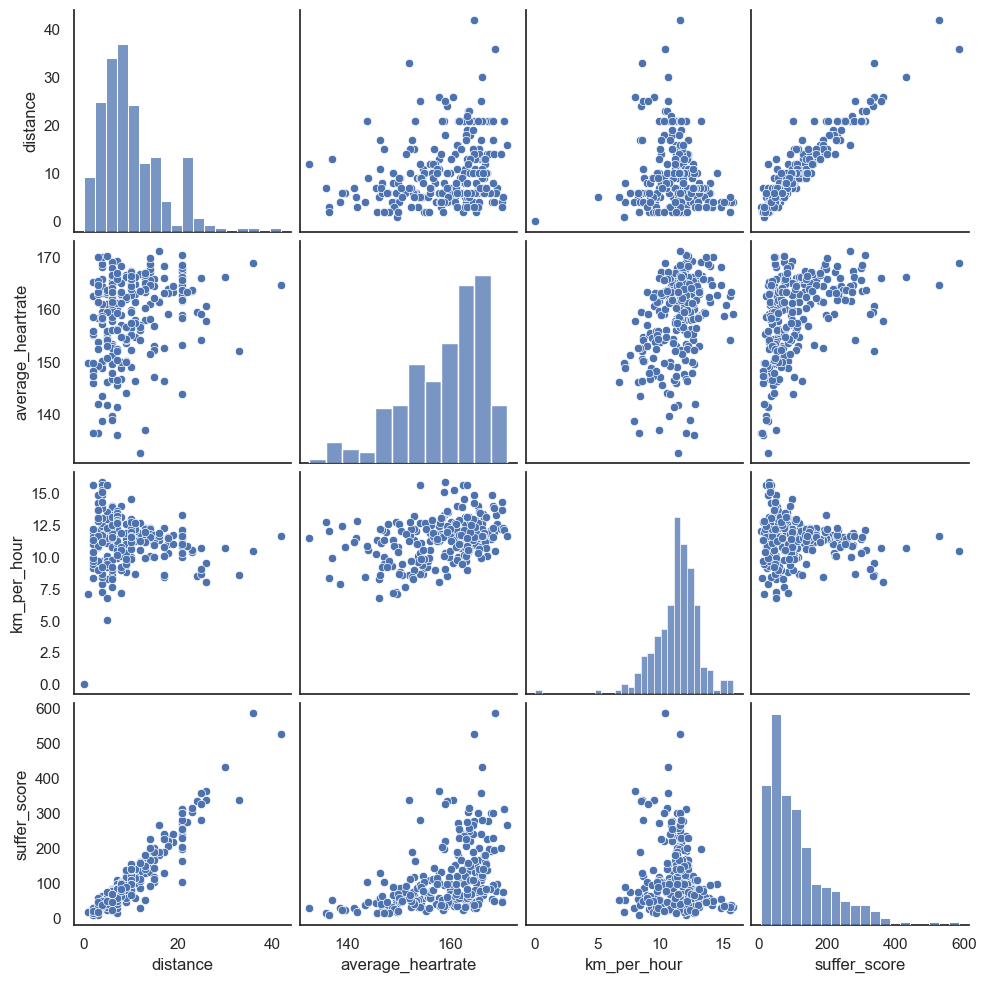

In [129]:
pp_df = df[['distance', 'average_heartrate', 'km_per_hour', 'suffer_score']]
sns.pairplot(pp_df);

In [130]:
df.describe().round(0)

,elapsed_time,distance,moving_time,month_num,year,day,day_of_year,week_of_year
count,282.0,282.0,282.0,282.0,282.0,282.0,282.0,282.0
mean,3469.0,10.0,3318.0,6.0,2023.0,16.0,178.0,26.0
std,2364.0,7.0,2309.0,3.0,1.0,9.0,101.0,14.0
min,700.0,0.0,689.0,1.0,2021.0,1.0,2.0,1.0
25%,1878.0,5.0,1794.0,3.0,2022.0,9.0,83.0,12.0
50%,2947.0,8.0,2806.0,7.0,2022.0,17.0,190.0,28.0
75%,4251.0,13.0,4119.0,9.0,2024.0,24.0,265.0,38.0
max,14595.0,42.0,14220.0,12.0,2024.0,31.0,364.0,52.0


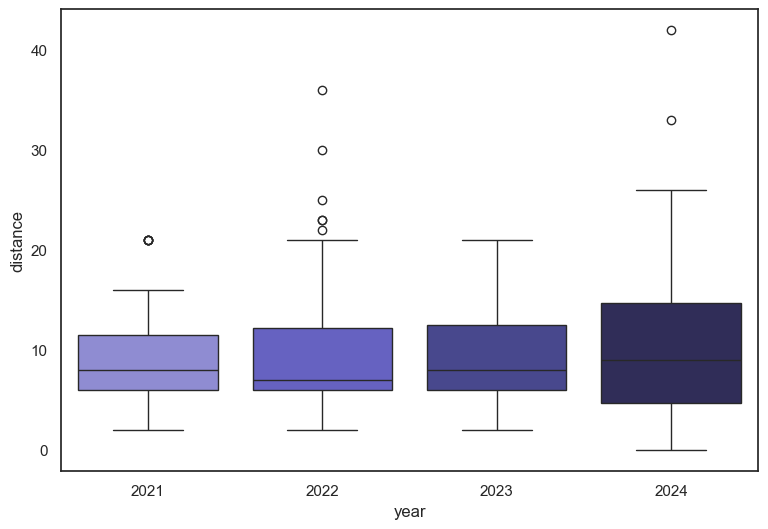

In [131]:
palette_box = ["#8481DD", "#5752D1", "#3C3D99", "#2A265F"]
fig, ax = plt.subplots()
sns.set(style="whitegrid", font_scale=1)
sns.boxplot(x="year", y="distance", hue="year", data=df, palette=palette_box)
ax.legend_.remove()
plt.gcf().set_size_inches(9, 6)

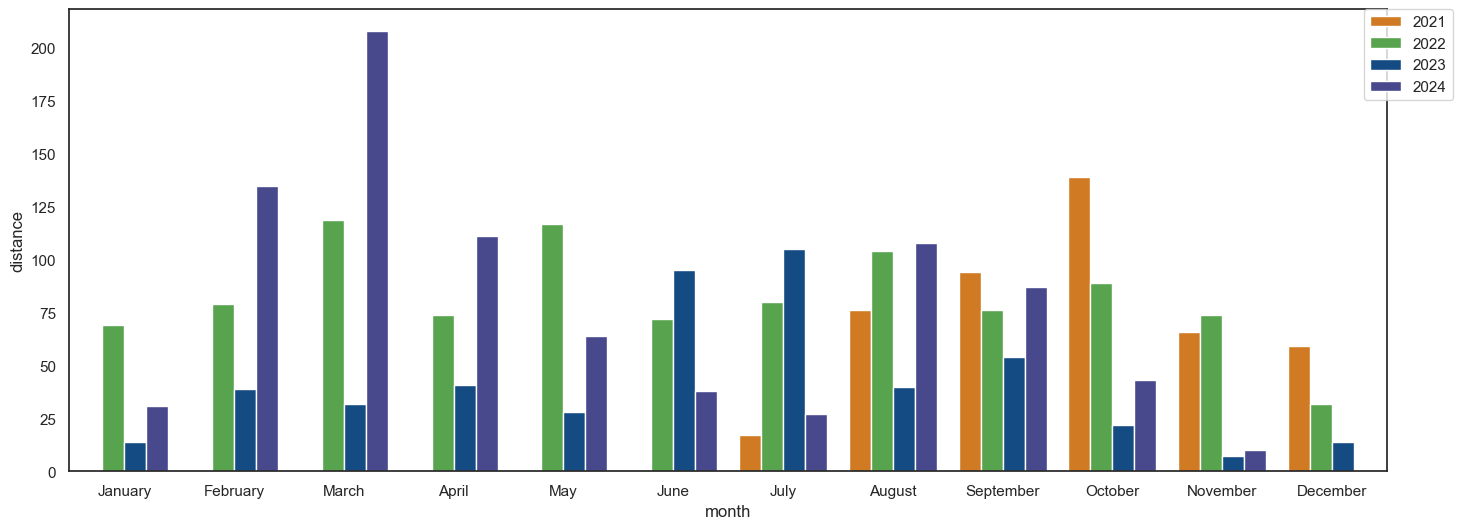

In [132]:
palette_bar = ["#EC7A08", "#4CB140", "#004B95", "#3C3D99"]

sns.set_style('white')
sns.barplot(x='month', y='distance', data=df, hue='year', errorbar=None, estimator=np.sum, palette=palette_bar,
           order=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"])

plt.gcf().set_size_inches(17, 6)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)

plt.show()

/var/folders/20/v81skv3s7vdb3xb49dlqvzp40000gn/T/ipykernel_37722/1066936321.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




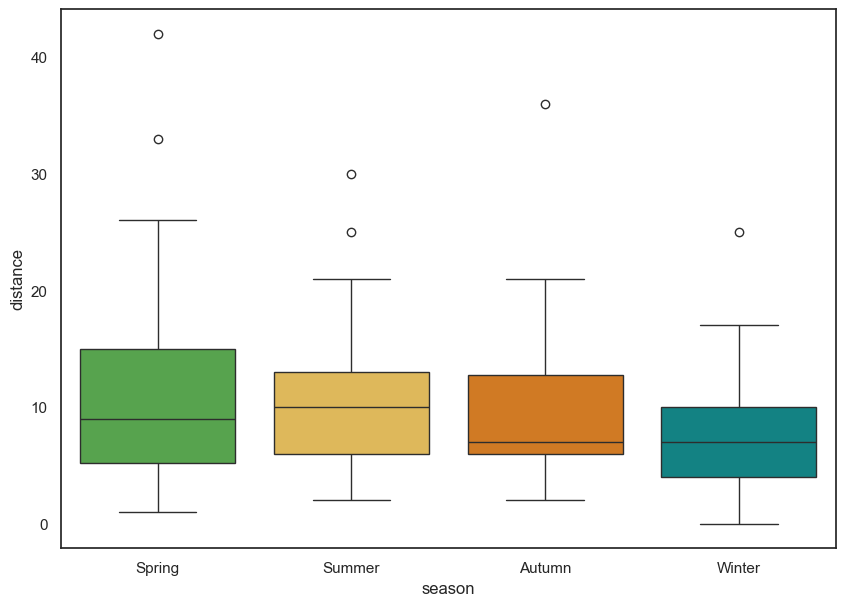

In [133]:
df['season'] = 'unknown'
df.loc[(df["month"].isin(["March", "April", "May"])), 'season'] = 'Spring'
df.loc[(df["month"].isin(["June", "July", "August"])), 'season'] = 'Summer'
df.loc[(df["month"].isin(["September", "October", "November"])), 'season'] = 'Autumn'
df.loc[(df["month"].isin(["December", "January", "February"])), 'season'] = 'Winter'

palette_season = ["#4CB140", "#F4C145", "#EC7A08", "#009596"]
ax = sns.boxplot(x="season", y="distance", palette=palette_season,
                    data=df,
                    order =["Spring", 'Summer', 'Autumn', 'Winter'])
plt.gcf().set_size_inches(10, 7)

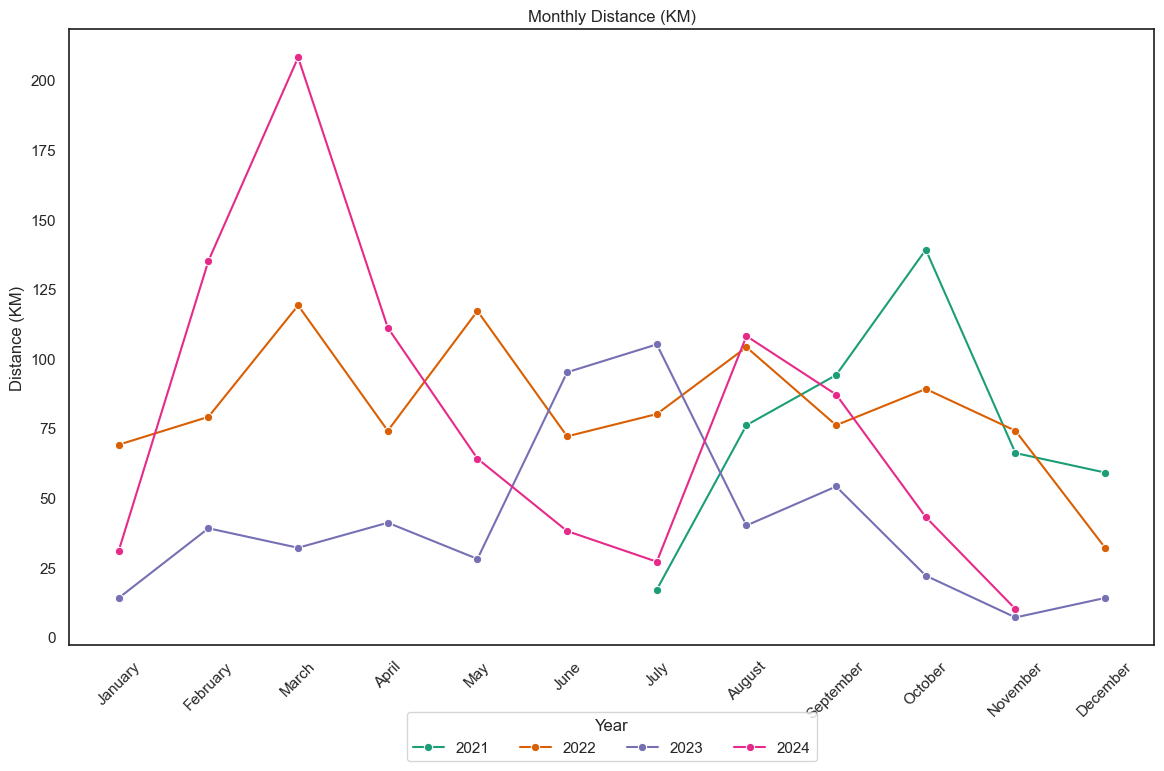

In [134]:
df_monthly = df.groupby(['year', 'month_num', 'month'], as_index=False)['distance'].sum()
df_monthly['month_year'] = df_monthly['month'] + ' ' + df_monthly['year'].astype(str)
df_monthly = df_monthly.sort_values(['year', 'month_num'])

sns.set_style('white')

sns.lineplot(x='month_num', y='distance', hue='year', data=df_monthly,
             palette='Dark2', marker="o")

month_labels = {1: 'January', 2: 'February', 3: 'March', 4: 'April',
                5: 'May', 6: 'June', 7: 'July', 8: 'August',
                9: 'September', 10: 'October', 11: 'November', 12: 'December'}

plt.xticks(ticks=list(month_labels.keys()), labels=list(month_labels.values()), rotation=45)

plt.title('Monthly Distance (KM)')
plt.xlabel('')
plt.ylabel('Distance (KM)')
plt.legend(title='Year', loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=4)

plt.gcf().set_size_inches(14, 8)

plt.show()


In [135]:
df.dtypes

start_date_local        datetime64[ns, UTC]
type                                 object
elapsed_time                          int64
distance                              int64
moving_time                           int64
total_elevation_gain                 object
max_heartrate                        object
average_heartrate                    object
average_cadence                      object
max_speed                            object
average_speed                        object
location_country                     object
suffer_score                         object
gear_id                              object
moving_minutes                       object
km_per_hour                          object
avg_pace                             object
start_time                           object
start_date                           object
month                                object
month_num                             int32
year                                  int32
day                             

In [136]:
# Calender heat map
df['dato'] = pd.to_datetime(df['dato'])

fig = calplot(
    df,
    x='dato',      
    y='distance',   
    years_title=True,
    gap=0,
    colorscale='oranges',
)
fig.update_layout(
    title_x=0.5,  
    height=1200,  
    width=1200   
    
)

fig.show()

In [137]:
df_grouped = df.groupby('gear_id').agg({
    'distance': 'sum', 
    'avg_pace': 'mean'  
}).reset_index()

fig = px.sunburst(
    df_grouped,
    path=['gear_id'],       
    values='distance',       
    hover_data={'avg_pace': True}  
)

fig.update_traces(
    hovertemplate='<b>%{label}</b><br>Distance: %{value}<br>Avg Pace: %{customdata[0]:.2f}'
)

fig.show()

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/plotly/express/_core.py:1745: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [138]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


In [139]:
target = 'distance' 

features = ['day_of_year', 'week_of_year']  

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

future_dates = pd.date_range(start='2024-11-01', end='2025-12-31')
future_df = pd.DataFrame({'start_date_local': future_dates})
future_df['day_of_year'] = future_df['start_date_local'].dt.dayofyear
future_df['week_of_year'] = future_df['start_date_local'].dt.isocalendar().week

future_df['predicted_distance'] = model.predict(future_df[['day_of_year', 'week_of_year']])
future_df['predicted_distance'] = pd.to_numeric(future_df['predicted_distance'], errors='coerce').fillna(0).astype('int64')
future_df['day_of_year'] = future_df['start_date_local'].dt.date

future_df['day_of_year'] = future_df['start_date_local'].dt.dayofyear
future_df['predicted_distance'] = future_df['predicted_distance'].clip(lower=0, upper=15)  # Adjust upper bound based on your data

future_df.head()


Mean Squared Error: 48.89623356672109


,start_date_local,day_of_year,week_of_year,predicted_distance
0,2024-11-01,306,44,9
1,2024-11-02,307,44,9
2,2024-11-03,308,44,9
3,2024-11-04,309,45,9
4,2024-11-05,310,45,9


In [140]:
future_df.dtypes

start_date_local      datetime64[ns]
day_of_year                    int32
week_of_year                  UInt32
predicted_distance             int64
dtype: object

In [141]:
print(future_df[['start_date_local', 'predicted_distance']])


    start_date_local  predicted_distance
0         2024-11-01                   9
1         2024-11-02                   9
2         2024-11-03                   9
3         2024-11-04                   9
4         2024-11-05                   9
5         2024-11-06                   9
6         2024-11-07                   9
7         2024-11-08                   9
8         2024-11-09                   9
9         2024-11-10                   9
10        2024-11-11                   9
11        2024-11-12                   9
12        2024-11-13                   9
13        2024-11-14                   9
14        2024-11-15                   9
15        2024-11-16                   9
16        2024-11-17                   9
17        2024-11-18                   9
18        2024-11-19                   9
19        2024-11-20                   9
20        2024-11-21                   9
21        2024-11-22                   9
22        2024-11-23                   9
23        2024-1

In [142]:
pd.set_option('display.max_rows', None)  # To display all rows
pd.set_option('display.max_columns', None)  # To display all columns
print(future_df)

    start_date_local  day_of_year  week_of_year  predicted_distance
0         2024-11-01          306            44                   9
1         2024-11-02          307            44                   9
2         2024-11-03          308            44                   9
3         2024-11-04          309            45                   9
4         2024-11-05          310            45                   9
5         2024-11-06          311            45                   9
6         2024-11-07          312            45                   9
7         2024-11-08          313            45                   9
8         2024-11-09          314            45                   9
9         2024-11-10          315            45                   9
10        2024-11-11          316            46                   9
11        2024-11-12          317            46                   9
12        2024-11-13          318            46                   9
13        2024-11-14          319            46 

In [143]:

fig_future = calplot(
    future_df,
    x='start_date_local',        
    y='predicted_distance',      
    years_title=True,
    gap=0,
    colorscale='blues'
)
fig_future.show()